In [1]:
from src import tools
import xarray as xr 
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns 
import numpy as np 
from scipy import stats 

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# Open MDA8 O3 output for all three climate scenarios 

# Present-day
#ref = tools.get_ensemble_ds("ref", "MDA8_O3")
ref = xr.open_dataset(fr"/home/eleroy/proj-dirs/OZCLIM/data/analysis_data/GCHP_CAM_public/GCHP.all_ref_c48.MDA8_O3.april-august.nc4")
ref = ref*1e9 #ppbv
ref = tools.mask_ocean_c48(ref)
ref = ref.chunk({"sim": -1, "time": -1})

#refSNOx = tools.get_ensemble_ds("refSNOx", "MDA8_O3")*1e9 # ppbv
refSNOx = xr.open_dataset(fr"/home/eleroy/proj-dirs/OZCLIM/data/analysis_data/GCHP_CAM_public/GCHP.all_refSNOx_c48.MDA8_O3.april-august.nc4")
refSNOx = refSNOx*1e9 #ppbv
refSNOx = tools.mask_ocean_c48(refSNOx)
refSNOx = refSNOx.chunk({"sim": -1, "time": -1})

# Future-high
#refshort = tools.get_ensemble_ds("refshort", "MDA8_O3")*1e9 # ppbv
refshort = xr.open_dataset(fr"/home/eleroy/proj-dirs/OZCLIM/data/analysis_data/GCHP_CAM_public/GCHP.all_refshort_c48.MDA8_O3.april-august.nc4")
refshort = refshort*1e9 #ppbv
refshort = tools.mask_ocean_c48(refshort)
refshort = refshort.chunk({"sim": -1, "time": -1})

#refSNOxshort = tools.get_ensemble_ds("refSNOxshort", "MDA8_O3")*1e9 # ppbv
refSNOxshort = xr.open_dataset(fr"/home/eleroy/proj-dirs/OZCLIM/data/analysis_data/GCHP_CAM_public/GCHP.all_refSNOxshort_c48.MDA8_O3.april-august.nc4")
refSNOxshort = refSNOxshort*1e9 #ppbv
refSNOxshort = tools.mask_ocean_c48(refSNOxshort)
refSNOxshort = refSNOxshort.chunk({"sim": -1, "time": -1})

# Future-low
#polshort = tools.get_ensemble_ds("pol3.7short", "MDA8_O3")*1e9 # ppbv
polshort = xr.open_dataset(fr"/home/eleroy/proj-dirs/OZCLIM/data/analysis_data/GCHP_CAM_public/GCHP.all_polshort_c48.MDA8_O3.april-august.nc4")
polshort = polshort*1e9 #ppbv
polshort = tools.mask_ocean_c48(polshort)
polshort = polshort.chunk({"sim": -1, "time": -1})

#polSNOxshort = tools.get_ensemble_ds("pol3.7SNOxshort", "MDA8_O3")*1e9 # ppbv
polSNOxshort = xr.open_dataset(fr"/home/eleroy/proj-dirs/OZCLIM/data/analysis_data/GCHP_CAM_public/GCHP.all_polSNOxshort_c48.MDA8_O3.april-august.nc4")
polSNOxshort = polSNOxshort*1e9 #ppbv
polSNOxshort = tools.mask_ocean_c48(polSNOxshort)
polSNOxshort = polSNOxshort.chunk({"sim": -1, "time": -1})


In [5]:
def calc_region_mean(ds, months, region_num):
    """Helper function to compute regional mean for given dataset."""
    selected = ds["SpeciesConc_O3"].sel(time=ds["SpeciesConc_O3"].time.dt.month.isin(months))
    if "lev" in ds.dims:
        ds = ds.isel(lev=0, drop=True)
    region = tools.crop_regionmask_ar6_c48(selected, region_num)
    return region.mean(dim=["nf", "Xdim", "Ydim"])

def get_values(months, region_num):
    # List of datasets to process
    datasets = {
        'ref': ref,
        'refSNOx': refSNOx,
        'refshort': refshort,
        'refSNOxshort': refSNOxshort,
        'polshort': polshort,
        'polSNOxshort': polSNOxshort
    }

    # Compute regional means for all datasets
    means = {name: calc_region_mean(ds, months, region_num) for name, ds in datasets.items()}

    # Calculate the historical 99th percentile
    ref_99th = means['ref'].quantile(0.99, dim=["time", "sim"])
    print("extreme value:")
    print(ref_99th.values)

    # Calculate days above the historical 99th percentile for each dataset, get annual
    days_above_99 = {}
    for name, mean_data in means.items():
        # Set threshold
        condition = mean_data > ref_99th
        # Count days exceeding threshold
        days_above = mean_data.where(condition).resample(time='1Y').count(dim='time')
        days_above_99[name] = days_above

    # Return results
    return (days_above_99['ref'], days_above_99['refSNOx'], days_above_99['refshort'],
            days_above_99['refSNOxshort'], days_above_99['polshort'], days_above_99['polSNOxshort'])

In [6]:
results = get_values([4,5,6,7,8], 5)

extreme value:
[74.03071065]


In [8]:
def plot_bars(months, region_num, ax):
    results = get_values(months, region_num)
    
    # helper function to calculate total days in months
    def total_days_in_months(months):
    
        if 2 in months:
            print("Warning: assumming no-leap years.")

        # dictionary mapping month number to days in that month for non-leap years
        days_in_month = {
            1: 31,
            2: 28,
            3: 31,
            4: 30,
            5: 31,
            6: 30,
            7: 31,
            8: 31,
            9: 30,
            10: 31,
            11: 30,
            12: 31
        }
    
        total = 0
        for month in months:
            # add the number of days for each month in the list
            total += days_in_month.get(month, 0)  # defaults to 0 if month not found
        return total

    # compute percentage counts for each dataset
    counts = [(np.sum(result.values) / (total_days_in_months(months)*80)) * 100 for result in results]
    
    # bar properties
    bar_props = [
        {'color': 'grey',      'edgecolor': 'black',     'hatch': None,  'label': 'Historical',         'text_color': 'black'},
        {'color': 'white',     'edgecolor': 'black',     'hatch': '////',  'label': 'Historical-lowNOx',    'text_color': 'black'},
        {'color': 'red',       'edgecolor': 'red',       'hatch': None,  'label': 'High-Warming',       'text_color': 'red'},
        {'color': 'white',     'edgecolor': 'red',       'hatch': '////',  'label': 'High-Warming-lowNOx',  'text_color': 'red'},
        {'color': 'dodgerblue','edgecolor': 'dodgerblue','hatch': None,  'label': 'Low-Warming',        'text_color': 'dodgerblue'},
        {'color': 'white',     'edgecolor': 'dodgerblue','hatch': '////',  'label': 'Low-Warming-lowNOx',   'text_color': 'dodgerblue'}
    ]
    
    bar_width = 0.2
    x_positions = [i * bar_width for i in range(len(counts))]
    
    # plot bars
    for x, count, props in zip(x_positions, counts, bar_props):
        ax.bar(x, count, width=bar_width, color=props['color'], alpha=0.7, 
               edgecolor=props['edgecolor'], hatch=props['hatch'], label=props['label'])
        ax.text(x + 0.05*bar_width / 2, count, f"{count:.1f}", ha='center', va='bottom', 
                fontsize=7, color=props['text_color'])
    
    return ax

extreme value:
[74.03071065]
extreme value:
[67.92352103]
extreme value:
[71.51834387]


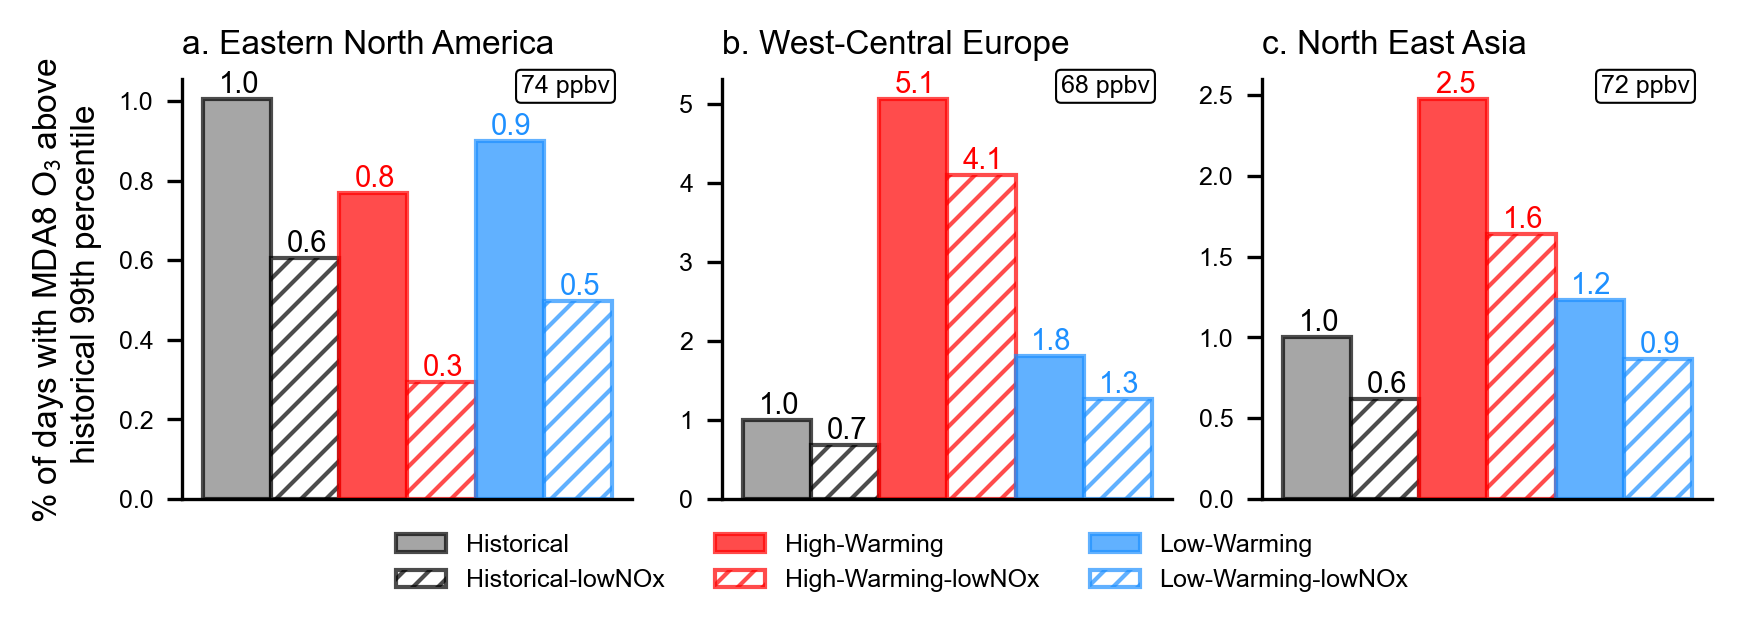

In [14]:
tools.set_matplotlib_font("Arial")

fig_width_in = 6
fig_height_in = 2

fig = plt.figure(figsize=(fig_width_in, fig_height_in), dpi=300)

gs1 = GridSpec(1, 3, top=0.90, bottom=0.20, left=0.10, right=0.95, hspace=0.2, wspace=0.2)
ax0 = fig.add_subplot(gs1[0, 0])
ax1 = fig.add_subplot(gs1[0, 1])
ax2 = fig.add_subplot(gs1[0, 2])

ax = [ax0, ax1, ax2]

titles = [
    "a. Eastern North America", "b. West-Central Europe", "c. North East Asia",
]

ax0 = plot_bars([4,5,6,7,8], 5, ax[0])
ax1 = plot_bars([4,5,6,7,8], 17, ax[1])
ax2 = plot_bars([4,5,6,7,8], 58, ax[2])

ylabel = "% of days with MDA8 O$_3$ above \n historical 99th percentile"
ax0.set_ylabel(ylabel, fontsize=8)

extremes =['74 ppbv', '68 ppbv', '72 ppbv']

for idx, axis in enumerate(ax):
    axis.spines[['right', 'top']].set_visible(False)
    axis.tick_params(axis='both', labelsize=6)  
    axis.set_xticklabels([])
    axis.tick_params(bottom = False) 
    axis.tick_params(axis='both', labelsize=6)  
    axis.set_title(titles[idx], loc="left", fontsize=8)
    axis.text(
        0.95, 1.01, extremes[idx],
        ha='right', 
        va='top',
        transform=axis.transAxes,
        color='black', 
        fontsize=6,
        bbox=dict(
            boxstyle='round,pad=0.2',
            facecolor='white',
            edgecolor='black',
            linewidth=0.5,
        )
)

handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=3, bbox_to_anchor=(0.5, 0.18), fontsize=6, frameon=False)

################################
plt.savefig("Fig3_new.pdf")
